In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats
import matplotlib.ticker as ticker

import plotly.io as pio
pio.renderers.default = "png"
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

In [45]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df)

df shape: (2580, 80)


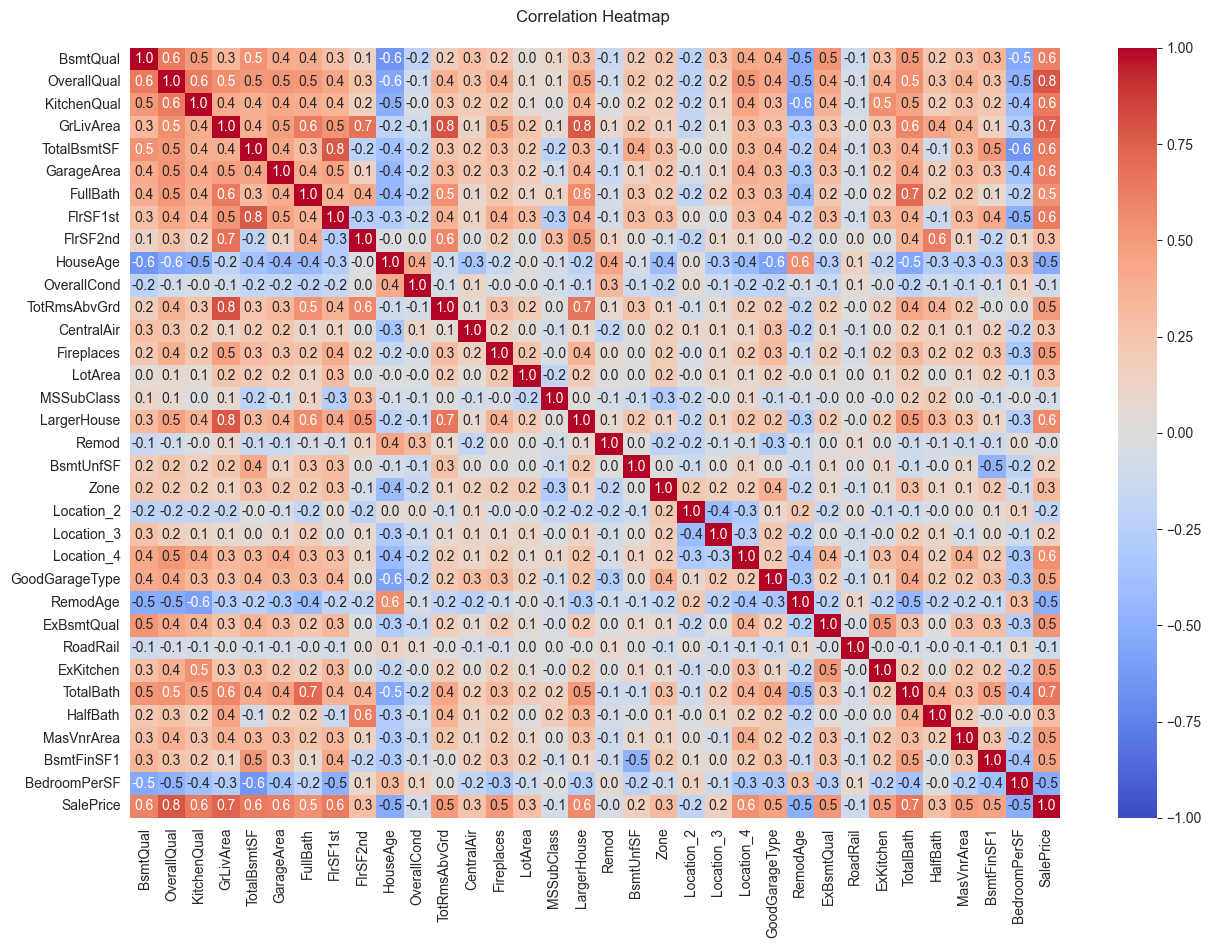

In [46]:
feature_selection = ['BsmtQual' , 'OverallQual' , 'KitchenQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea' , 'FullBath' , 'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'LargerHouse' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location_2', 'Location_3', 'Location_4', 'GoodGarageType',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'ExKitchen' , 'TotalBath', 
                    'HalfBath',# 'ExQual', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

plt.figure(figsize=(15, 10))

corr_mat = data[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [47]:
skewness = data[feature_selection].skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 0.75])
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

data['LotArea'] = np.log(data['LotArea'])

LotArea         13.647537
ExKitchen        4.212534
RoadRail         3.690437
ExBsmtQual       3.571738
MasVnrArea       2.740317
Location_4       1.937549
MSSubClass       1.339800
Location_3       1.083856
FlrSF1st         1.045575
BsmtUnfSF        0.981279
GrLivArea        0.943880
FlrSF2nd         0.804334
BedroomPerSF     0.767331
Zone            -1.733407
CentralAir      -3.705920
dtype: float64


In [48]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

In [49]:
temp = pd.concat([X_train, y_train], axis=1)
temp['PriceSF'] = temp['SalePrice']/temp['TotalSF']

In [50]:
#Location Feature

temp = pd.concat([X_train, y_train], axis=1)
temp['PriceSF'] = temp['SalePrice']/temp['TotalSF']

temp.groupby('Neighborhood').PriceSF.median().sort_values()

Neighborhood
SWISU       53.254889
OldTown     58.290155
MeadowV     59.142193
Edwards     60.200669
IDOTRR      60.674157
NPkVill     63.563133
BrkSide     64.021142
NAmes       64.596828
BrDale      65.275201
NWAmes      66.558787
Sawyer      67.550562
Blmngtn     69.912664
Landmrk     70.256410
SawyerW     70.985401
Mitchel     71.605960
ClearCr     73.146837
Blueste     74.289406
CollgCr     74.971165
Crawfor     75.260556
Gilbert     75.987842
StoneBr     80.516521
Somerst     80.934195
Timber      81.463675
Veenker     83.282429
NridgHt     83.674065
NoRidge     83.984693
Greens      86.447897
GrnHill    109.853529
Name: PriceSF, dtype: float64

# Model

### Standardization

In [51]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

## Linear Regression

In [52]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.926  0.9287 0.9306 0.9322 0.9476]
Mean shuffled cross validation score: 0.933
RMSE Shuffled cross validation score: [0.0958 0.0988 0.0924 0.0975 0.0839]
RMSE Mean shuffled cross validation score: 0.0937


In [53]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9314
RMSE Test score: 0.098


In [54]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16577.260068863634
17026.47152468649


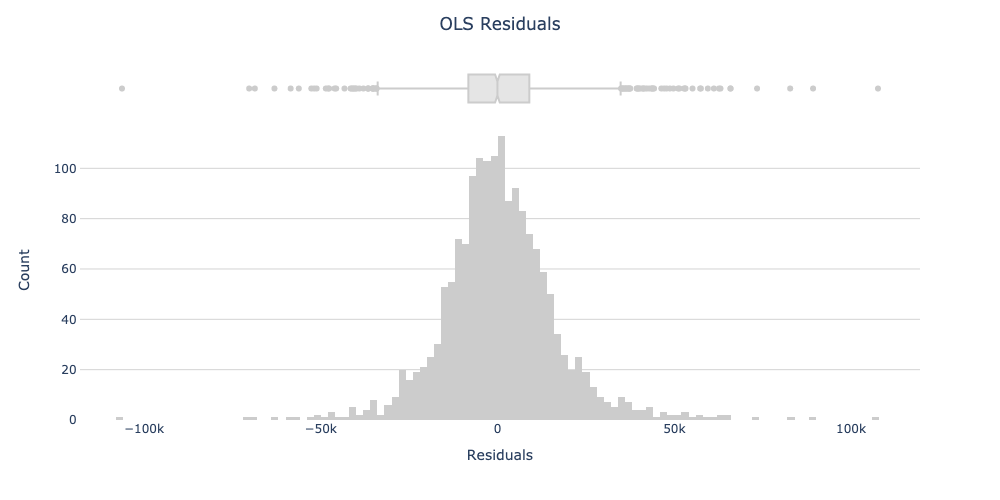

In [55]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

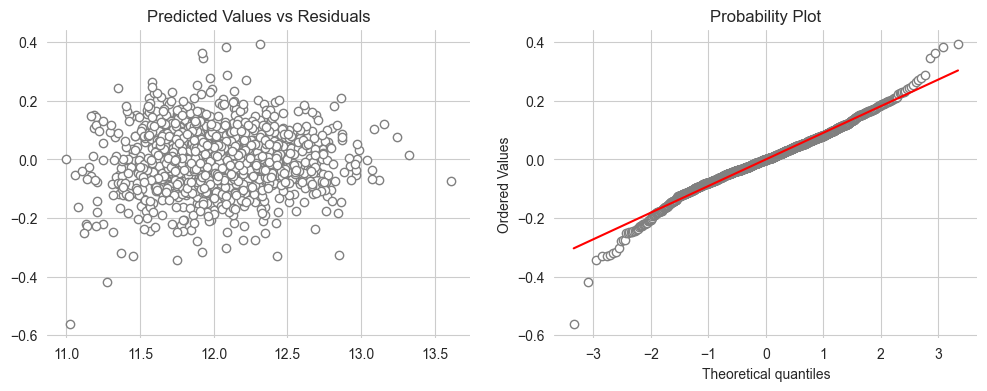

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [57]:
res = stats.shapiro(residuals)
res.statistic

0.9815422296524048

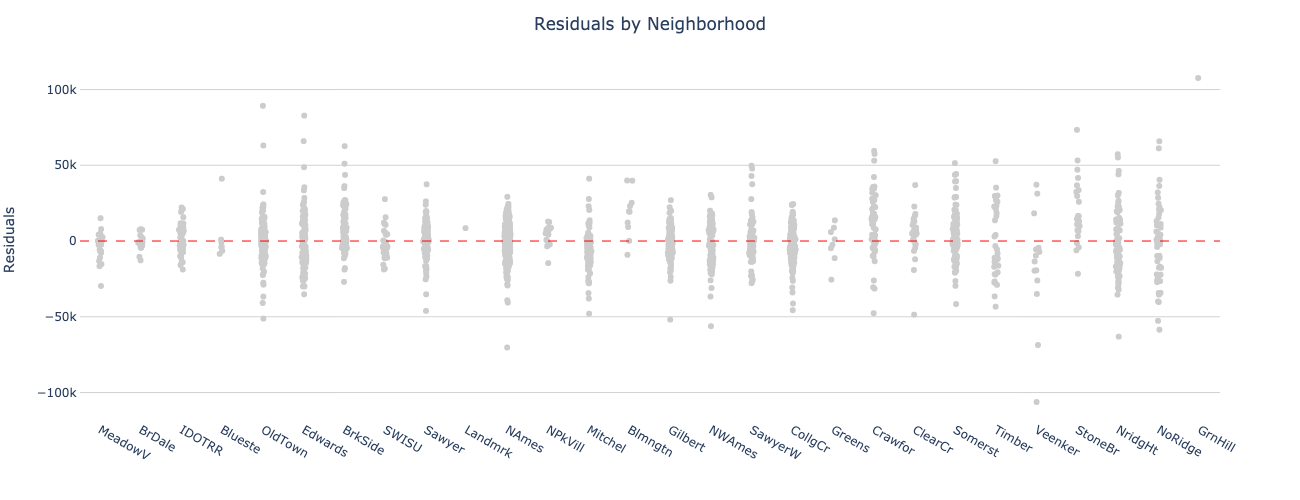

In [58]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

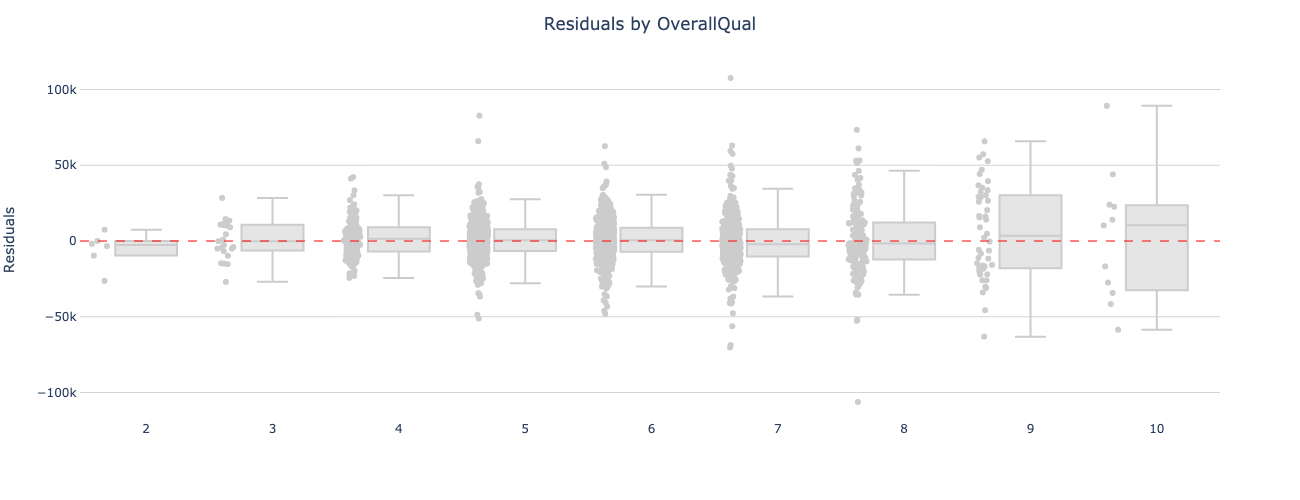

In [59]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

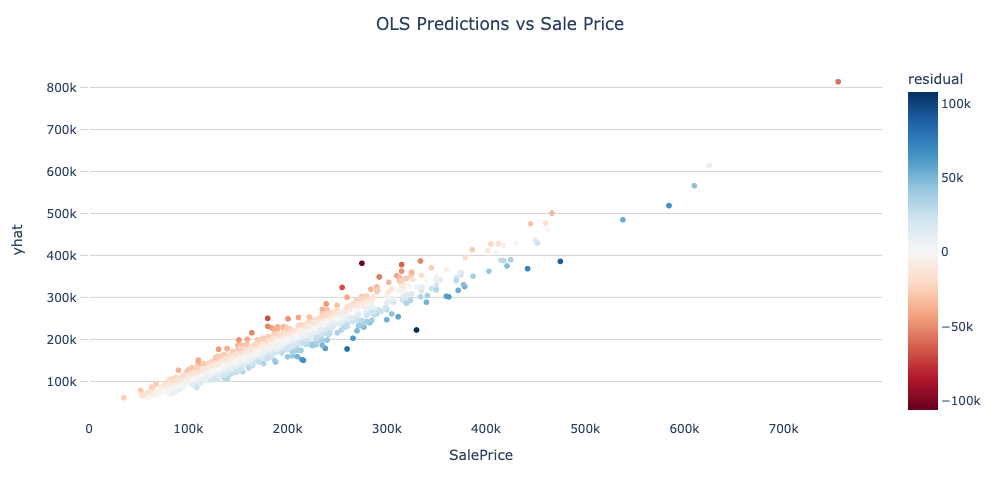

In [60]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [61]:
lasso = LassoCV(cv=3)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Best alpha: 0.00090542266527849
RMSE: 0.0982969275527312


In [62]:
kf = KFold(n_splits=2, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9295 0.9364]
Mean shuffled cross validation score: 0.933
RMSE Shuffled cross validation score: [0.0961 0.0918]
RMSE Mean shuffled cross validation score: 0.094


In [63]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16562.73603084466
17103.87650005853


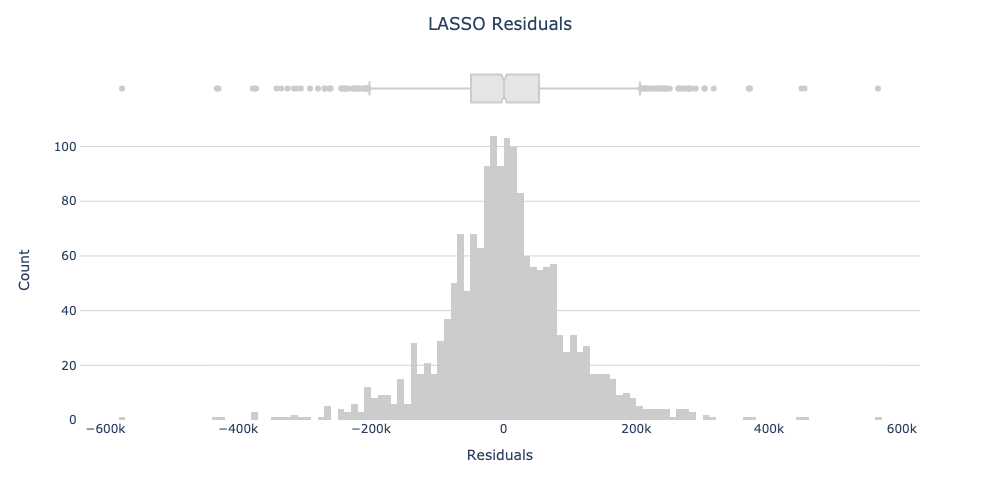

In [64]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

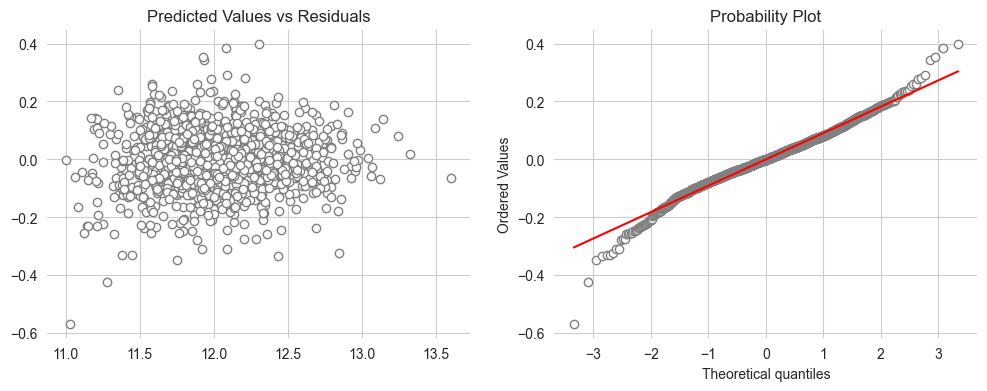

In [65]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [66]:
res = stats.shapiro(residuals)
res.statistic

0.9806006550788879

## Ridge

In [67]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Best alpha: 10.0
RMSE: 0.09794712044358453


In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9259 0.9287 0.931  0.9327 0.9473]
Mean shuffled cross validation score: 0.9331
RMSE Shuffled cross validation score: [0.0958 0.0988 0.0921 0.0972 0.0841]
RMSE Mean shuffled cross validation score: 0.0936


In [69]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16574.63980708449
17024.62102551669


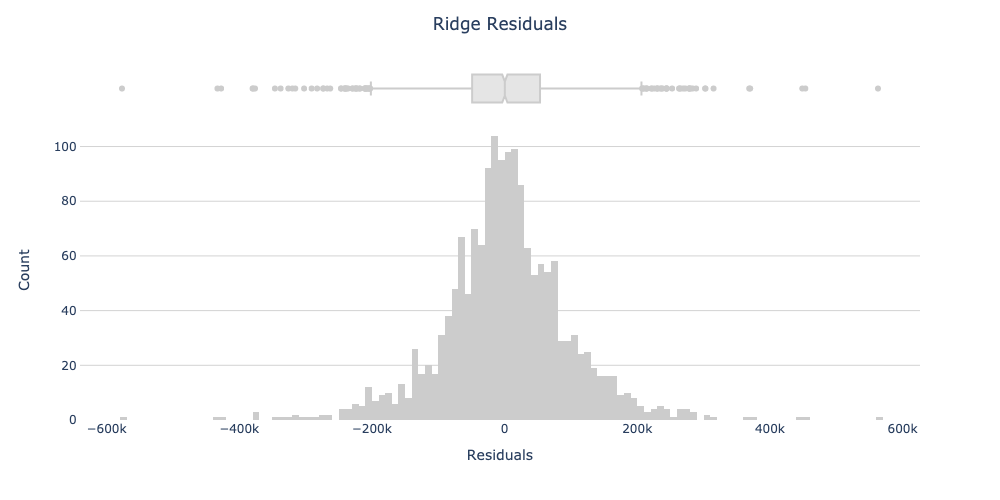

In [70]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

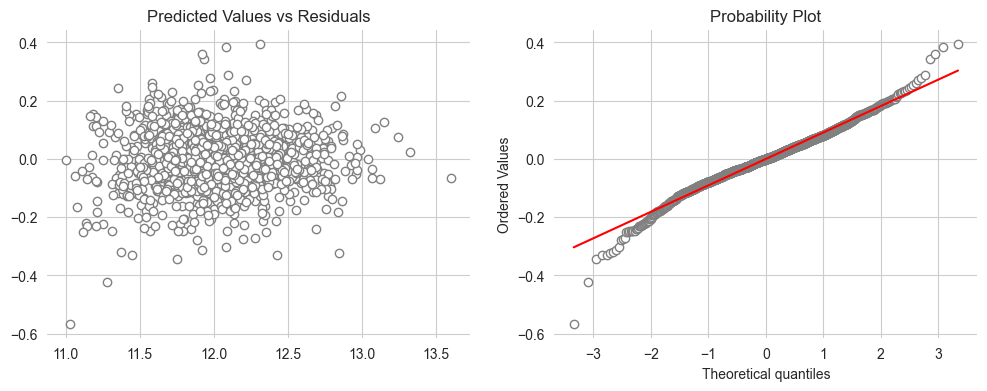

In [71]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [72]:
res = stats.shapiro(residuals)
res.statistic

0.9813001155853271

## Stats model

In [91]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                    Fireplaces + LotArea + MSSubClass + Remod +\
                    BsmtUnfSF + Zone + Location_2 + Location_3 + Location_4 +\
                    RemodAge + ExBsmtQual + RoadRail + ExKitchen + HalfBath + BedroomPerSF +\
                    MasVnrArea + BsmtFinSF1 +\
                    GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0.9/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     793.5
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:08:54   Log-Likelihood:                 1615.3
No. Observations:                1678   AIC:                            -3169.
Df Residuals:                    1647   BIC:                            -3000.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0174      0.003   4769.815      0.000      12.012      12.022
BsmtQual                 0.0089      0.004      2.021      0.043       0.000       0.017
OverallQual              0.0917      0.004     22.676      0.000       0.084       0.100
GrLivArea                0.0816      0.025      3.270      0.001       0.033       0.131
TotalBsmtSF              0.0518      0.007      7.561      0.000       0.038       0.065
GarageArea               0.0246      0.003      8.142      0.000       0.019       0.031
FullBath                -0.0012      0.004     -0.319      0.750      -0.008       0.006
FlrSF1st                 0.0266      0.019      1.385      0.166      -0.011       0.064
FlrSF2nd                 0.0370      0.022      1.669      0.095      -0.006       0.081
HouseAge                -0.0515      0.005     -9.576      0.000      -0.062      -0.041
OverallCond              0.0506      0.003     16.686      0.000       0.045       0.057
TotRmsAbvGrd             0.0002      0.005      0.039      0.969      -0.009       0.009
CentralAir               0.0184      0.003      6.991      0.000       0.013       0.024
Fireplaces               0.0216      0.003      7.768      0.000       0.016       0.027
LotArea                  0.0438      0.003     12.707      0.000       0.037       0.051
MSSubClass              -0.0033      0.003     -1.065      0.287      -0.009       0.003
Remod                   -0.0035      0.003     -1.156      0.248      -0.009       0.002
BsmtUnfSF               -0.0213      0.005     -3.930      0.000      -0.032      -0.011
Zone                     0.0154      0.003      4.964      0.000       0.009       0.022
Location_2               0.0049      0.004      1.279      0.201      -0.003       0.012
Location_3               0.0268      0.004      6.574      0.000       0.019       0.035
Location_4               0.0353      0.004      8.292      0.000       0.027       0.044
RemodAge                -0.0222      0.004     -6.163      0.000      -0.029      -0.015
ExBsmtQual               0.0078      0.003      2.455      0.014       0.002       0.014
RoadRail                -0.0109      0.002     -4.673      0.000      -0.016      -0.006
ExKitchen                0.0110      0.003      4.029      0.000       0.006       0.016
HalfBath                 0.0013      0.003      0.379      0.705      -0.005       0.008
BedroomPerSF            -0.0145      0.004     -3.988      0.000      -0.022      -0.007
MasVnrArea               0.0036      0.003      1.329      0.184      -0.002       0.009
BsmtFinSF1               0.0184      0.006      3.302      0.001       0.007       0.029
GrLivArea:Fireplaces    -0.0043      0.002     -1.733      0.083      -0.009       0.001
=========================================================

In [92]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

mape_train = mean_absolute_percentage_error(np.exp(y_train), np.exp(yhat_train))
mape_test = mean_absolute_percentage_error(np.exp(y_test), np.exp(yhat_test))

print(train_rmse_non_log)
print(test_rmse_non_log)
print('\n')
print(mape_train)
print(mape_test)

16737.62430195668
17082.016514282554


0.07003076540766713
0.07375300085587602


In [75]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

0.09240748691349449
0.09838782205857749


## Interactions with Location

In [76]:
feature_selection = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

In [77]:
data = df_engineered(df, Reg=False)

data['LotArea'] = np.log(data['LotArea'])

In [78]:
location=4
temp = data[data.Location==location]

X_train_loc, X_test_loc, y_train_loc, y_test_loc = \
    train_test_split(temp.drop(columns='SalePrice'), temp[['SalePrice']], test_size=0.30, random_state=42)

### Standardization

In [79]:
feature_selection_2 = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'Remod',
                    'BsmtUnfSF' , 'Zone' ,
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

In [80]:
scaler = StandardScaler()

X_train_loc = X_train_loc.reset_index(drop=True)
X_test_loc = X_test_loc.reset_index(drop=True)

y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)

In [81]:
X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 + \
                        GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

results_fu = model.fit()

if location == 4:
        alpha = 0.1
        l1 = 1
elif location == 1:
    alpha = 10
    l1 = 0
elif location == 2:
    alpha = 5
    l1 = 1
else:
    alpha=0
    l1 = 0

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=l1, alpha=alpha/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     132.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          3.45e-122
Time:                        17:07:12   Log-Likelihood:                 301.64
No. Observations:                 255   AIC:                            -549.3
Df Residuals:                     228   BIC:                            -453.7
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.4536      0.005   2326.893      0.000      12.443      12.464
BsmtQual                -0.0423      0.017     -2.515      0.013      -0.076      -0.009
OverallQual              0.0711      0.008      8.697      0.000       0.055       0.087
GrLivArea               -0.4546      0.316     -1.438      0.152      -1.077       0.168
TotalBsmtSF              0.0782      0.025      3.119      0.002       0.029       0.128
GarageArea               0.0116      0.007      1.602      0.111      -0.003       0.026
FullBath                -0.0117      0.009     -1.344      0.180      -0.029       0.005
FlrSF1st                 0.5094      0.267      1.909      0.058      -0.017       1.035
FlrSF2nd                 0.6120      0.319      1.917      0.057      -0.017       1.241
HouseAge                -0.0297      0.024     -1.251      0.212      -0.077       0.017
OverallCond              0.0102      0.010      1.057      0.292      -0.009       0.029
TotRmsAbvGrd            -0.0190      0.012     -1.635      0.104      -0.042       0.004
CentralAir                    0   4.35e-16          0      1.000   -8.57e-16    8.57e-16
Fireplaces               0.0166      0.007      2.413      0.017       0.003       0.030
LotArea                  0.0530      0.009      6.011      0.000       0.036       0.070
MSSubClass              -0.0067      0.009     -0.757      0.450      -0.024       0.011
Remod                    0.0044      0.006      0.771      0.441      -0.007       0.016
BsmtUnfSF               -0.0491      0.015     -3.315      0.001      -0.078      -0.020
Zone                    -0.0071      0.006     -1.156      0.249      -0.019       0.005
RemodAge                -0.0311      0.020     -1.575      0.117      -0.070       0.008
ExBsmtQual               0.0484      0.015      3.185      0.002       0.018       0.078
RoadRail                -0.0011      0.005     -0.226      0.821      -0.011       0.009
KitchenQual              0.0212      0.007      2.847      0.005       0.007       0.036
HalfBath                 0.0004      0.009      0.041      0.967      -0.018       0.019
BedroomPerSF            -0.0066      0.011     -0.629      0.530      -0.027       0.014
MasVnrArea               0.0113      0.006      1.867      0.063      -0.001       0.023
BsmtFinSF1              -0.0070      0.016     -0.444      0.658      -0.038       0.024
GrLivArea:Fireplaces    -0.0027      0.006     -0.472      0.637      -0.014       0.009
==============================================================================
Omnibus:                        0.877   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.865
Skew:                           0.140   Prob(JB):                        0.649
Kurtosis

In [82]:
yhat_train_loc = final.predict(X_train_scaled_loc)
yhat_test_loc = final.predict(X_test_scaled_loc)

train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

20459.915773255205
21579.058579349774


In [83]:
import math

unscaled_coef = final.params[1:]

transformed_coef = []
for i in unscaled_coef:
    j = math.exp(i)
    transformed_coef.append(j)

In [84]:
coef_effect = [(i - 1)*df.SalePrice.mean() for i in transformed_coef]

var_impact = pd.DataFrame(data=[X_train_scaled_loc.columns, coef_effect]).T
var_impact.columns = ["variable", "1-unit change"]
var_impact

,variable,1-unit change
0,BsmtQual,-7382.866487
1,OverallQual,13126.124405
2,GrLivArea,-65043.391041
3,TotalBsmtSF,14488.95112
4,GarageArea,2073.014566
5,FullBath,-2065.525972
6,FlrSF1st,118296.679607
7,FlrSF2nd,150297.713373
8,HouseAge,-5214.585717
9,OverallCond,1828.560465


In [85]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for location in (1,2,3,4):

    temp = data[data.Location==location]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]

    if location == 4:
        alpha = 0.1
        l1 = 1
    elif location == 1:
        alpha = 10
        l1 = 0
    elif location == 2:
        alpha = 5
        l1 = 1
    else:
        alpha=0
        l1 = 0

    results_fr = model.fit_regularized(L1_wt=l1, alpha=alpha/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    mape_train = mean_absolute_percentage_error(np.exp(y_train_loc), np.exp(yhat_train_loc))
    mape_test = mean_absolute_percentage_error(np.exp(y_test_loc), np.exp(yhat_test_loc))

    print(train_rmse_non_log)
    print(test_rmse_non_log)
    #print(mape_train)
    #print(mape_test)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train_loc = pd.concat([df_train_loc, X_train_loc], axis=1)
    df_train = pd.concat([df_train, df_train_loc], axis=0)


    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

15055.618506727656
15511.499503180923
12130.478738944863
14281.51956350142
15749.010274124312
15662.275724752446
20459.915773255212
21579.05857934958


In [86]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

mape_train = mean_absolute_percentage_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train))
mape_test = mean_absolute_percentage_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train))

print(train_rmse_non_log)
print(test_rmse_non_log)
print('\n')
print(mape_train)
print(mape_test)

15327.776907087029
16247.324397647013


0.06595768594863088
0.07044157585434264
